In [162]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

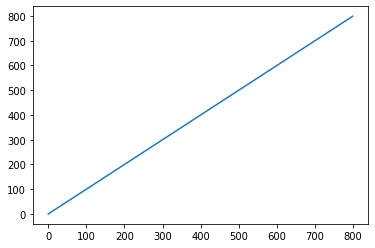

In [99]:
x = torch.linspace(0, 799, 800)
plt.plot(range(800), x.numpy())

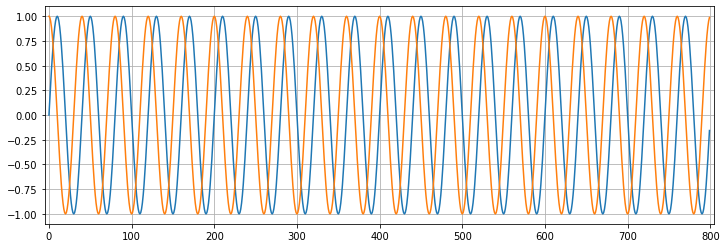

In [100]:
PI = 3.1416

y = torch.sin(x * PI / 20)
c = torch.cos(x * PI / 20)  # Just to experiment
plt.figure(figsize=(12, 4))
plt.xlim(-5, 805)
plt.grid()
plt.plot(range(800), y)
plt.plot(range(800), c)

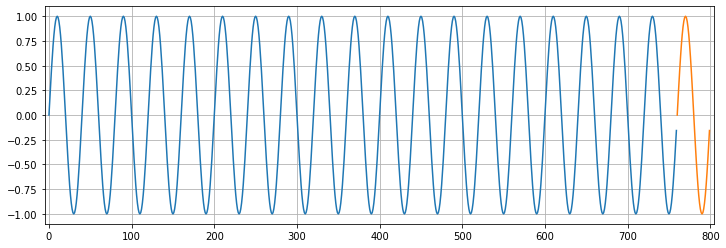

In [121]:
windows_size = 40
train_set = y[:-windows_size]
test_set = y[-windows_size:]

plt.figure(figsize=(12, 4))
plt.xlim(-5, 805)
plt.grid()
plt.plot(range(760), train_set)
plt.plot(range(760, 800), test_set)

In [142]:
def input_batch(dataset, ws):

    L = len(dataset)
    output = []

    for i in range(L - ws): # [([1, 2, 3, 4], [5]), (2, 3, 4, 5), [6]]. But the actual size is 40.
        sequence = dataset[i:i + ws]
        label = dataset[ws + i:ws + i + 1]
        output.append((sequence, label))

    return output

In [144]:
train_input = input_batch(train_set, windows_size)
print(len(train_input))

720


In [104]:
input = torch.tensor(train_input[0][0]).view(len(train_input[0][0]), 1, -1)
input.shape

<ipython-input-104-30999d441e67>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(train_input[0][0]).view(len(train_input[0][0]), 1, -1)


torch.Size([40, 1, 1])

In [168]:
class LSTMNetwork(nn.Module):
    """
    :param input_features - number of features in the input.
    :param hidden_size - number of neuron in the LSTM layer.
    :param output_features - number of features in the output.
    """
    def __init__(self, input_features=1, hidden_size=60, output_features=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_features, hidden_size, num_layers=2)
        self.linear = nn.Linear(hidden_size, output_features)
        self.hidden = (torch.zeros(2, 1, hidden_size), torch.zeros(2, 1, hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)

        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1]

In [169]:
torch.manual_seed(42)
model = LSTMNetwork()
model

LSTMNetwork(
  (lstm): LSTM(1, 60, num_layers=2)
  (linear): Linear(in_features=60, out_features=1, bias=True)
)

epoch: 1, loss: 0.10131115466356277
epoch: 2, loss: 0.09740225970745087
epoch: 3, loss: 0.01093461737036705
epoch: 4, loss: 0.00036771121085621417
epoch: 5, loss: 0.0004387653316371143
epoch: 6, loss: 0.0004947640118189156
epoch: 7, loss: 0.0005188591894693673
epoch: 8, loss: 0.0005203224718570709
epoch: 9, loss: 0.0005072768544778228
epoch: 10, loss: 0.00048585268086753786


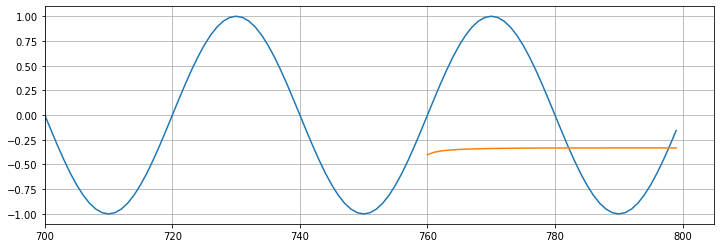

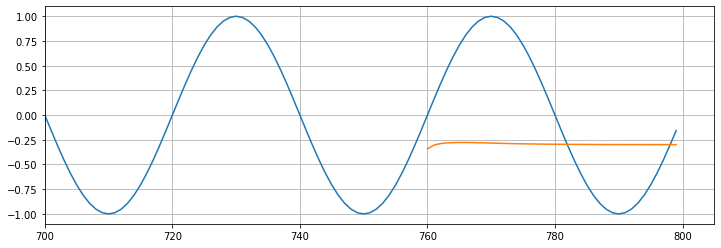

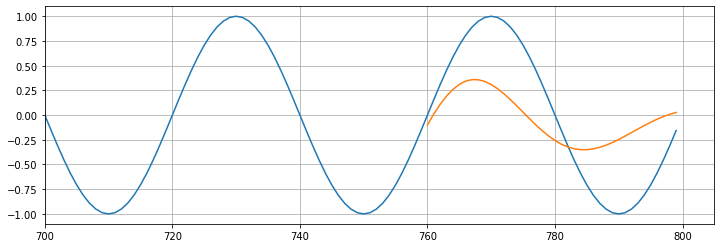

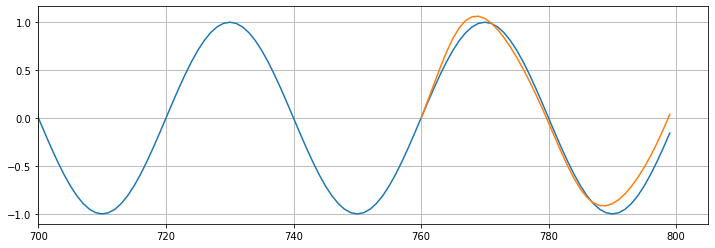

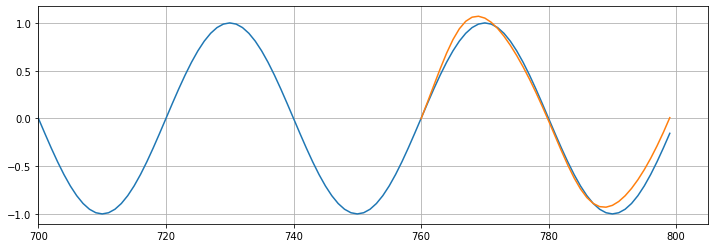

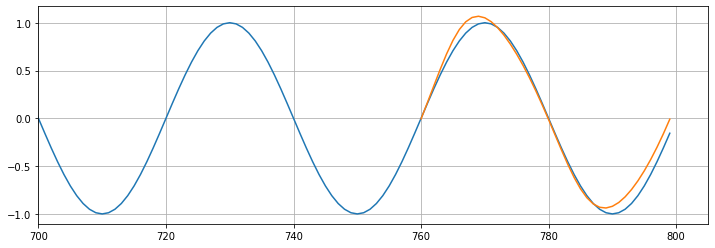

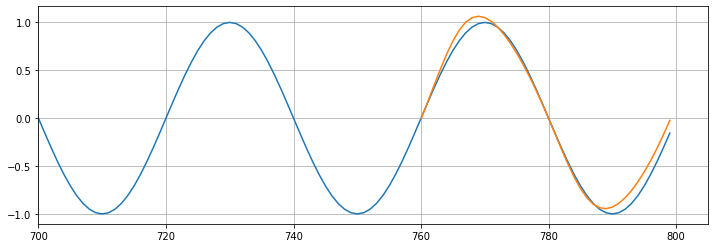

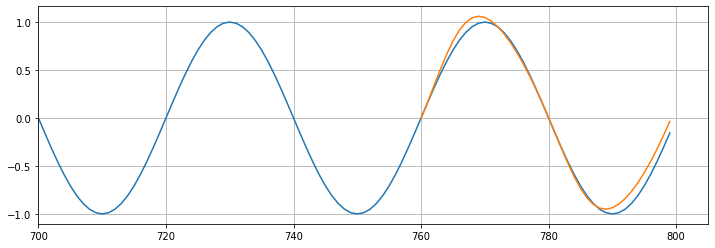

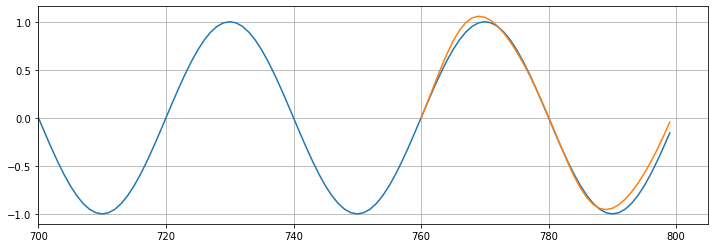

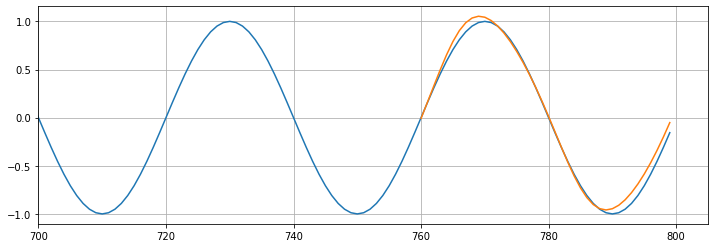

In [170]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 10
future = 40

for i in range(epochs):
    i += 1
    loss = 0
    for seq, label in train_input:

        model.hidden = (torch.zeros(2, 1, model.hidden_size), torch.zeros(2, 1, model.hidden_size))
        optimizer.zero_grad()

        y_pred = model(seq)
        loss = criterion(y_pred, label.view(-1))

        # back-propagate
        loss.backward()
        optimizer.step()

    print(f'epoch: {i}, loss: {loss}')

    # Test while training and see the convergence.
    preds = train_set[-windows_size:].tolist() # Grab the whole test set to predict next 40 futures points.
    for _ in range(future):

        seq = torch.FloatTensor(preds[-windows_size:])

        with torch.no_grad():

            model.hidden = (torch.zeros(2, 1, model.hidden_size), torch.zeros(2, 1, model.hidden_size))
            f_pred = model(seq)

            preds.append(f_pred.item())

        loss = criterion(torch.tensor(preds[-windows_size:]), test_set)

    plt.figure(figsize=(12, 4))
    plt.xlim(700, 805)
    plt.grid()
    plt.plot(y.numpy())
    plt.plot(range(760, 800), preds[-windows_size:])
    plt.show()

In [171]:
# Forecast model for the full dataset, 40 point into the future.

future = 40
preds = y[-windows_size:].tolist()

for _ in range(future):

    seq = torch.FloatTensor(preds[-windows_size:])

    with torch.no_grad():

        model.hidden = (torch.zeros(2, 1, model.hidden_size), torch.zeros(2, 1, model.hidden_size))

        y_pred = model(seq)

        preds.append(y_pred.item())

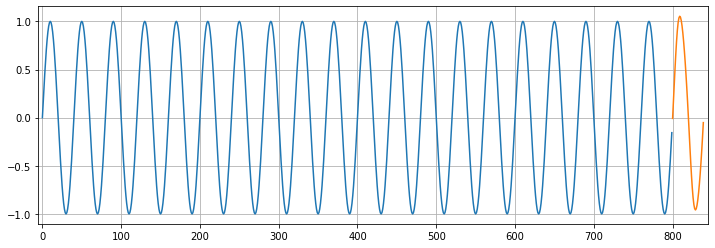

In [172]:
plt.figure(figsize=(12, 4))
plt.xlim(-5, 845)
plt.grid()
plt.plot(y)
plt.plot(range(800, 840), preds[-windows_size:])